## 이용량 결측치 처리

#### 노선 이용량을 활용성 지수로 변환
* 이용량 결측치 처리 과정에서 더 정확하게 분석하고 시각화한 후 예측
* 예측 성능 검증 진행

In [36]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [37]:
meta_data = pd.read_csv("../data/total_data.csv")
data = pd.read_csv("../data/여진_total_busdata.csv")

In [38]:
data["총인구수"] = meta_data["총인구수"]
data["노인(수)"] = meta_data["노인(수)"]
data["총인구수"] = data["총인구수"].apply(lambda x: int(x.replace(",", "")))
data["노인(수)"] = data["노인(수)"].apply(lambda x: int(x.replace(",", "")))

In [39]:
data = data[data['city_name'] != '산청군']

In [40]:
data.columns

Index(['city_name', 'routeno', 'routetp', 'startnodenm', 'endnodenm',
       'startvehicletime', 'endvehicletime', 'intervaltime', 'intervalsattime',
       'intervalsuntime', 'usage', '노선정류장수', '노선거리(km)', '굴곡도', 'start', 'end',
       'total_operating_time', 'interval_avg', 'num_bus', '총인구수', '노인(수)'],
      dtype='object')

In [41]:
use_col = [ 
    'city_name',
    'routetp',
    '노선정류장수', 
    '노선거리(km)', 
    '굴곡도', 
    'total_operating_time', 
    'interval_avg', 
    'num_bus', 
    '총인구수', 
    '노인(수)', 
    'usage'
    ]

In [42]:
df = data[use_col]
df.head()

,city_name,routetp,노선정류장수,노선거리(km),굴곡도,total_operating_time,interval_avg,num_bus,총인구수,노인(수),usage
0,창원시,마을버스,105,55.9,2.0,990.0,40.000000,24,1003731,276574,33931.0
1,창원시,마을버스,83,53.5,1.7,865.0,170.000000,5,1003731,276574,2558.0
2,창원시,마을버스,74,43.8,2.6,545.0,220.000000,2,1003731,276574,299.0
3,창원시,마을버스,35,21.1,1.0,1010.0,12.142857,83,1003731,276574,63612.0
4,창원시,마을버스,39,8.8,1.8,1000.0,17.000000,58,1003731,276574,68306.0


In [43]:
df['routetp'].value_counts()

routetp
농어촌(일반)버스    1053
일반버스          988
지선버스          209
간선버스           88
좌석버스           58
마을버스           48
심야버스            2
급행버스            1
Name: count, dtype: int64

### y log 변환

In [44]:
df_train = df[~df['usage'].isna()]
df_test = df[df['usage'].isna()]

import numpy as np
usage_origin = df_train['usage']
df_train['usage'] = np.log1p(df_train['usage'])

### 범주형 변수 전처리 (One-hot Encoding)

#### routetp 

In [45]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

t_routetp = df_train['routetp']
v_routetp = df_test['routetp']

# 전체 데이터에서 고유한 범주를 추출
all_routetp = np.unique(df['routetp'])

ohe = OneHotEncoder(
    categories=[all_routetp],
    sparse_output=False
    )
ohe.fit(t_routetp.values.reshape(-1,1))

dense_matrix_tr = ohe.transform(t_routetp.values.reshape(-1,1)) #df_train
dense_matrix_val = ohe.transform(v_routetp.values.reshape(-1,1)) #df_test

In [46]:
# tdata_train, dense_matrix_tr 데이터 합치기
df_train = pd.concat([
    df_train.reset_index(drop=True),
    pd.DataFrame(dense_matrix_tr, columns=ohe.categories_[0])],
    axis=1
    )

In [47]:
# data_test, dense_matrix_val 데이터 합치기
df_test = pd.concat([
    df_test.reset_index(drop=True), 
    pd.DataFrame(dense_matrix_val, columns=ohe.categories_[0])], 
    axis=1
    )

#### city_name

In [48]:
t_city = df_train['city_name']
v_city = df_test['city_name']

# 전체 데이터에서 고유한 범주를 추출
all_city = np.unique(df['city_name'])

ohe = OneHotEncoder(
    categories=[all_city],
    sparse_output=False
    )
ohe.fit(t_city.values.reshape(-1,1))

dense_matrix_tr = ohe.transform(t_city.values.reshape(-1,1)) #df_train
dense_matrix_val = ohe.transform(v_city.values.reshape(-1,1)) #df_test

In [49]:
# df_train, dense_matrix_tr 데이터 합치기
df_train = pd.concat([
    df_train.reset_index(drop=True),
    pd.DataFrame(dense_matrix_tr, columns=ohe.categories_[0])],
    axis=1
    )

In [50]:
# df_test, dense_matrix_val 데이터 합치기
df_test = pd.concat([
    df_test.reset_index(drop=True), 
    pd.DataFrame(dense_matrix_val, columns=ohe.categories_[0])], 
    axis=1
    )

In [51]:
df_train = df_train.drop(columns=['routetp','city_name'])
df_test = df_test.drop(columns=['routetp','city_name'])

In [52]:
df_train.head()

,노선정류장수,노선거리(km),굴곡도,total_operating_time,interval_avg,num_bus,총인구수,노인(수),usage,간선버스,...,양산시,의령군,진주시,창녕군,창원시,통영시,하동군,함안군,함양군,합천군
0,105,55.9,2.0,990.0,40.000000,24,1003731,276574,10.432114,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,83,53.5,1.7,865.0,170.000000,5,1003731,276574,7.847372,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,74,43.8,2.6,545.0,220.000000,2,1003731,276574,5.703782,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,35,21.1,1.0,1010.0,12.142857,83,1003731,276574,11.060573,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,39,8.8,1.8,1000.0,17.000000,58,1003731,276574,11.131768,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [53]:
df_test.head()

,노선정류장수,노선거리(km),굴곡도,total_operating_time,interval_avg,num_bus,총인구수,노인(수),usage,간선버스,...,양산시,의령군,진주시,창녕군,창원시,통영시,하동군,함안군,함양군,합천군
0,33,15.2,2.5,425.0,94.857143,4,1003731,276574,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,33,15.1,4.4,445.0,88.857143,5,1003731,276574,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,35,17.4,2.3,425.0,94.857143,4,1003731,276574,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,33,15.8,4.4,445.0,88.857143,5,1003731,276574,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,31,10.8,4.7,137.0,40.000000,3,1003731,276574,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### 연속형 변수 전처리

In [54]:
col = [ 
    '노선정류장수', 
    '노선거리(km)', 
    '굴곡도', 
    'total_operating_time', 
    'interval_avg', 
    'num_bus', 
    '총인구수', 
    '노인(수)'
    ]

In [55]:
# standardaxscaler 사용
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df_train[col])

df_train[col] = scaler.transform(df_train[col])
df_test[col] = scaler.transform(df_test[col])

In [56]:
total = pd.concat([df_train, df_test],axis=0)
total

,노선정류장수,노선거리(km),굴곡도,total_operating_time,interval_avg,num_bus,총인구수,노인(수),usage,간선버스,...,양산시,의령군,진주시,창녕군,창원시,통영시,하동군,함안군,함양군,합천군
0,0.530928,0.511581,0.169231,0.913076,0.031337,0.321839,1.00000,1.000000,10.432114,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.417526,0.487412,0.123077,0.814298,0.177579,0.103448,1.00000,1.000000,7.847372,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.371134,0.389728,0.261538,0.561427,0.233825,0.068966,1.00000,1.000000,5.703782,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.170103,0.161128,0.015385,0.928880,0.000000,1.000000,1.00000,1.000000,11.060573,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.190722,0.037261,0.138462,0.920978,0.005464,0.712644,1.00000,1.000000,11.131768,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,0.128866,0.249385,0.169231,0.451472,0.126651,0.080460,0.01584,0.036119,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1267,0.128866,0.249385,0.169231,0.451472,0.126651,0.080460,0.01584,0.036119,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1268,0.128866,0.249385,0.169231,0.451472,0.126651,0.080460,0.01584,0.036119,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1269,0.128866,0.249385,0.169231,0.451472,0.126651,0.080460,0.01584,0.036119,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### MICE 성능비교

In [57]:
#from impyute.imputation.cs import mice
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### 정량적 (통계적 수치)

In [58]:
impute_total_data = pd.DataFrame(
    IterativeImputer(random_state=0).fit_transform(total)
    )
impute_total_data.columns = total.columns
impute_total_data["usage"] = np.expm1(impute_total_data["usage"])

In [59]:
impute_total_data[impute_total_data["usage"] <= 0]

,노선정류장수,노선거리(km),굴곡도,total_operating_time,interval_avg,num_bus,총인구수,노인(수),usage,간선버스,...,양산시,의령군,진주시,창녕군,창원시,통영시,하동군,함안군,함양군,합천군
1351,0.061856,0.120846,7.261538,0.451472,0.126651,0.08046,0.077668,0.122076,-0.881392,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
impute_total_data.loc[df_test.index]["usage"].describe()

count      1271.000000
mean      12447.407993
std       29146.578769
min           3.000000
25%         341.500000
50%        1595.000000
75%        7793.000000
max      335737.000000
Name: usage, dtype: float64

In [33]:
data

,city_name,routeno,routetp,startnodenm,endnodenm,startvehicletime,endvehicletime,intervaltime,intervalsattime,intervalsuntime,...,노선정류장수,노선거리(km),굴곡도,start,end,total_operating_time,interval_avg,num_bus,총인구수,노인(수)
0,창원시,1,마을버스,신전,창원역,540.0,2210.0,40.0,40.0,40.0,...,105,55.900000,2.0,340.000000,1330.000000,990.000000,40.000000,24,1003731,276574
1,창원시,2,마을버스,유등,창원역,725.0,2150.0,170.0,170.0,170.0,...,83,53.500000,1.7,445.000000,1310.000000,865.000000,170.000000,5,1003731,276574
2,창원시,3,마을버스,상리,진영시외주차장,750.0,1655.0,220.0,220.0,220.0,...,74,43.800000,2.6,470.000000,1015.000000,545.000000,220.000000,2,1003731,276574
3,창원시,7,마을버스,창원역,자여입구,620.0,2310.0,11.0,15.0,15.0,...,35,21.100000,1.0,380.000000,1390.000000,1010.000000,12.142857,83,1003731,276574
4,창원시,8,마을버스,창원역,삼성창원병원종점(8),600.0,2240.0,17.0,17.0,17.0,...,39,8.800000,1.8,360.000000,1360.000000,1000.000000,17.000000,58,1003731,276574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,합천군,660-1,농어촌(일반)버스,합천터미널,합천터미널,928.0,1614.0,128.1,114.6,118.0,...,27,29.863889,2.0,568.676575,974.532234,405.855659,124.728571,3,40756,23160
2509,합천군,670-2,농어촌(일반)버스,합천터미널,합천터미널,928.0,1614.0,128.1,114.6,118.0,...,27,29.863889,2.0,568.676575,974.532234,405.855659,124.728571,3,40756,23160
2510,합천군,810-3,농어촌(일반)버스,부림면정류장,합천터미널,928.0,1614.0,128.1,114.6,118.0,...,29,25.300000,1.3,568.676575,974.532234,405.855659,124.728571,3,40756,23160
2511,합천군,110-13,농어촌(일반)버스,부림면정류장,합천터미널,928.0,1614.0,128.1,114.6,118.0,...,27,29.863889,2.0,568.676575,974.532234,405.855659,124.728571,3,40756,23160


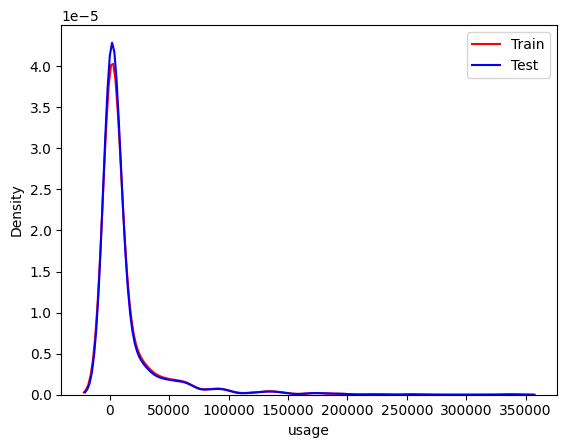

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(usage_origin, color="r", label="Train")
sns.kdeplot(impute_total_data.loc[df_test.index]["usage"], color="b", label="Test")
plt.legend()